## Import

In [1]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import stackstac
import xarray as xr
import datetime
import geopandas as gpd

import statsmodels.api as sm

## Wheat

### Clean Data

In [109]:
wheat_natl=pl.read_csv(r'C:\Users\Porter\Desktop\Huron\Research\county_yields\winter_wheat_natl.csv')



wheat_natl=wheat_natl.filter(pl.col('Program')=='SURVEY')
wheat_natl=wheat_natl.select(['Year','County','State ANSI','County ANSI','Value'])


wheat_natl=wheat_natl.with_columns(
   (( pl.col('State ANSI').cast(pl.Utf8).str.zfill(2)) +
   (pl.col('County ANSI').cast(pl.Utf8).str.zfill(3)))
   .alias('fips')
)
wheat_natl=wheat_natl.rename({'Value':'yield'})

#get rid of duplicates
wheat_natl = (
    wheat_natl
    .group_by(['fips', 'Year'])
    .agg([
        pl.col('yield').mean().alias('yield')
    ])
)


fips_count=((wheat_natl.group_by(pl.col('fips')).agg(pl.col('Year').count())))
fips_count=fips_count.rename({'Year':'fips_count'})


In [110]:
wheat_natl=wheat_natl.join(fips_count,on='fips')
wheat_natl=wheat_natl.sort(['Year','fips'],descending=True)

In [111]:
wheat_natl=wheat_natl.filter(pl.col('fips_count')>21)
wheat_natl['fips'].n_unique()

1036

### OLS

In [114]:
preds=[]
truth=[]
fips_list=[]


for county in wheat_natl['fips'].unique():
    sub=wheat_natl.filter(
        pl.col('fips')==county
    ).sort('Year',descending=True)


    length=int((len(sub))*(1/5))
    sub=sub.to_pandas()
    train=sub[length:]
    X=sm.add_constant(train['Year'])
    y=train['yield']

    model = sm.OLS(y,X)
    results = model.fit()
    
    test=sub[:length]
    X_test = sm.add_constant(test['Year'])  
    predictions = results.predict(X_test)


    preds.append(predictions)
    truth.append(test['yield'])
    fips_list.extend([county] * length)



In [115]:
import pandas as pd

all_preds = pd.concat(preds, ignore_index=True)
all_truth = pd.concat(truth, ignore_index=True)
results_df = pd.DataFrame({
    'fips': fips_list,
    'predicted': all_preds,
    'actual': all_truth
})
results_df

,fips,predicted,actual
0,18151,75.457193,63.1
1,18151,74.352632,71.1
2,18151,73.248070,83.3
3,18151,69.934386,71.7
4,45069,55.747018,48.0
...,...,...,...
5112,18037,73.666232,96.4
5113,18037,71.607710,83.3
5114,18037,70.578449,62.5
5115,18037,69.549188,68.3


In [116]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Assuming you already have a DataFrame called `results_df`
y_true = results_df['actual']
y_pred = results_df['predicted']

# R² Score
r2 = r2_score(y_true, y_pred)

# RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# MAE
mae = mean_absolute_error(y_true, y_pred)

# MAPE (in percent)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Print the results
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")


R²: 0.7003
RMSE: 11.3765
MAE: 8.8223
MAPE: 17.67%


C:\Users\Porter\AppData\Local\Temp\ipykernel_22376\4124835449.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


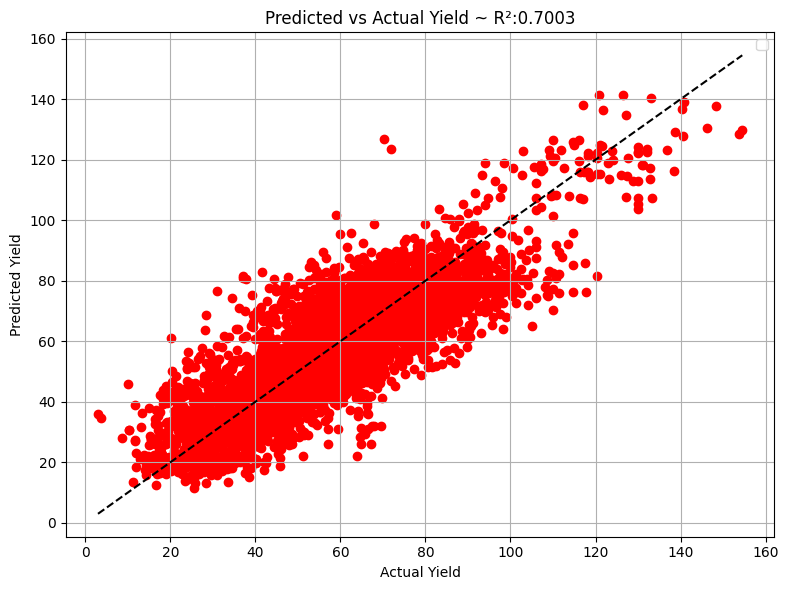

In [117]:

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(results_df['actual'], results_df['predicted'],color='red')

# Add y = x line
min_val = min(results_df['actual'].min(), results_df['predicted'].min())
max_val = max(results_df['actual'].max(), results_df['predicted'].max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black')

# Labels and title
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title(f'Predicted vs Actual Yield ~ R²:{np.round(r2,4)}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [118]:
results_df[results_df['fips']=='26063']

,fips,predicted,actual
1606,26063,112.420580,105.9
1607,26063,110.688928,97.9
1608,26063,108.957275,91.7
1609,26063,107.225623,94.7
1610,26063,105.493971,88.9
1611,26063,103.762319,83.1


## Soy

### Clean Data

In [119]:
#it is soy, i was too lazy to change the naming schemes


wheat_natl=pl.read_csv(r'C:\Users\Porter\Desktop\Huron\Research\county_yields\soy_county_yield.csv')



wheat_natl=wheat_natl.filter(pl.col('Program')=='SURVEY')
wheat_natl=wheat_natl.select(['Year','County','State ANSI','County ANSI','Value'])


wheat_natl=wheat_natl.with_columns(
   (( pl.col('State ANSI').cast(pl.Utf8).str.zfill(2)) +
   (pl.col('County ANSI').cast(pl.Utf8).str.zfill(3)))
   .alias('fips')
)
wheat_natl=wheat_natl.rename({'Value':'yield'})

#get rid of duplicates
wheat_natl = (
    wheat_natl
    .group_by(['fips', 'Year'])
    .agg([
        pl.col('yield').mean().alias('yield')
    ])
)


fips_count=((wheat_natl.group_by(pl.col('fips')).agg(pl.col('Year').count())))
fips_count=fips_count.rename({'Year':'fips_count'})


In [120]:
wheat_natl=wheat_natl.join(fips_count,on='fips')
wheat_natl=wheat_natl.sort(['Year','fips'],descending=True)

In [121]:
wheat_natl=wheat_natl.filter(pl.col('fips_count')>21)
wheat_natl['fips'].n_unique()

1066

In [122]:
# preds=[]
# truth=[]
# fips_list=[]

# for county in wheat_natl['fips'].head(3):
#     sub=wheat_natl.filter(
#         pl.col('fips')==county
#     ).sort('Year',descending=True)


#     length=int((len(sub))*(1/5))
#     sub=sub.to_pandas()
#     train=sub[length:]
#     X=sm.add_constant(train['Year'])
#     y=train['yield']

#     model = sm.OLS(y,X)
#     results = model.fit()

#     test=sub[:length]
#     X_test = sm.add_constant(test['Year'])  
#     predictions = results.predict(X_test)

#     preds.append(predictions)
#     truth.append(test['yield'])
#     fips_list.extend([county] * length)

       

In [123]:
# import pandas as pd

# all_preds = pd.concat(preds, ignore_index=True)
# all_truth = pd.concat(truth, ignore_index=True)
# results_df = pd.DataFrame({
#     'fips': fips_list,
#     'predicted': all_preds,
#     'actual': all_truth
# })
# results_df

### OLS

In [124]:
preds=[]
truth=[]
fips_list=[]


for county in wheat_natl['fips'].unique():
    sub=wheat_natl.filter(
        pl.col('fips')==county
    ).sort('Year',descending=True)


    length=int((len(sub))*(1/5))
    sub=sub.to_pandas()
    train=sub[length:]
    X=sm.add_constant(train['Year'])
    y=train['yield']

    model = sm.OLS(y,X)
    results = model.fit()
    
    test=sub[:length]
    X_test = sm.add_constant(test['Year'])  
    predictions = results.predict(X_test)


    preds.append(predictions)
    truth.append(test['yield'])
    fips_list.extend([county] * length)



In [125]:
all_preds = pd.concat(preds, ignore_index=True)
all_truth = pd.concat(truth, ignore_index=True)
results_df = pd.DataFrame({
    'fips': fips_list,
    'predicted': all_preds,
    'actual': all_truth
})
results_df

,fips,predicted,actual
0,29109,39.739699,33.6
1,29109,39.136617,41.9
2,29109,38.533534,30.6
3,29109,37.930451,38.0
4,29109,37.327368,35.2
...,...,...,...
4676,19069,60.222180,58.2
4677,19069,59.492030,59.4
4678,19069,58.761880,62.8
4679,19069,58.031729,59.7


In [126]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Assuming you already have a DataFrame called `results_df`
y_true = results_df['actual']
y_pred = results_df['predicted']

# R² Score
r2 = r2_score(y_true, y_pred)

# RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# MAE
mae = mean_absolute_error(y_true, y_pred)

# MAPE (in percent)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Print the results
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")


R²: 0.5973
RMSE: 7.1201
MAE: 5.2313
MAPE: 13.31%


C:\Users\Porter\AppData\Local\Temp\ipykernel_22376\4124835449.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


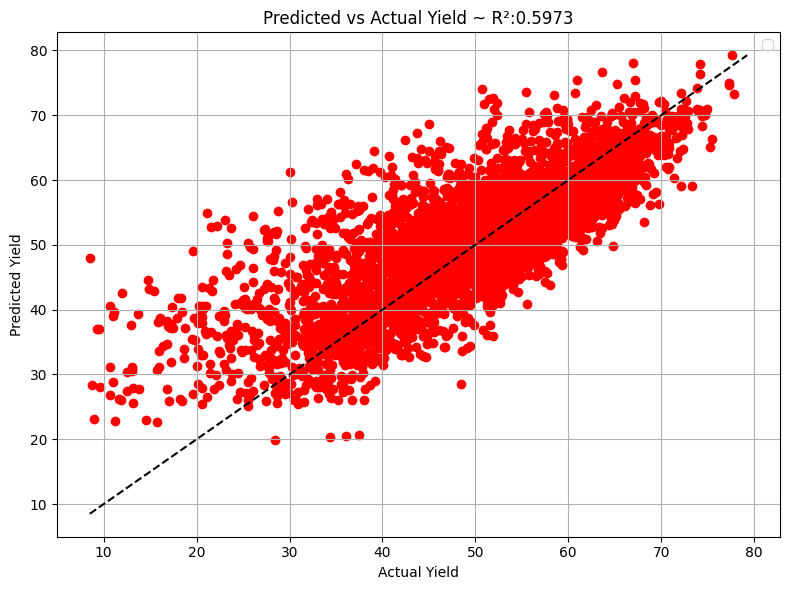

In [127]:

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(results_df['actual'], results_df['predicted'],color='red')

# Add y = x line
min_val = min(results_df['actual'].min(), results_df['predicted'].min())
max_val = max(results_df['actual'].max(), results_df['predicted'].max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black')

# Labels and title
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title(f'Predicted vs Actual Yield ~ R²:{np.round(r2,4)}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [128]:
results_df[results_df['fips']=='26063']

,fips,predicted,actual
1693,26063,56.807293,57.2
1694,26063,55.989549,48.5
1695,26063,55.171805,44.6
1696,26063,54.354060,57.2
1697,26063,53.536316,58.9


## Wheat (with 200 from Geojson)

### Clean Data

In [129]:
wheat_natl=pl.read_csv(r'C:\Users\Porter\Desktop\Huron\Research\county_yields\winter_wheat_natl.csv')



wheat_natl=wheat_natl.filter(pl.col('Program')=='SURVEY')
wheat_natl=wheat_natl.select(['Year','County','State ANSI','County ANSI','Value'])


wheat_natl=wheat_natl.with_columns(
   (( pl.col('State ANSI').cast(pl.Utf8).str.zfill(2)) +
   (pl.col('County ANSI').cast(pl.Utf8).str.zfill(3)))
   .alias('fips')
)
wheat_natl=wheat_natl.rename({'Value':'yield'})

#get rid of duplicates
wheat_natl = (
    wheat_natl
    .group_by(['fips', 'Year'])
    .agg([
        pl.col('yield').mean().alias('yield')
    ])
)


fips_count=((wheat_natl.group_by(pl.col('fips')).agg(pl.col('Year').count())))
fips_count=fips_count.rename({'Year':'fips_count'})


In [130]:
wheat_natl=wheat_natl.join(fips_count,on='fips')
wheat_natl=wheat_natl.sort(['Year','fips'],descending=True)

In [131]:
wheat_natl=wheat_natl.filter(pl.col('fips_count')>21)
wheat_natl['fips'].n_unique()

1036

### OLS

In [132]:
preds=[]
truth=[]
fips_list=[]


for county in wheat_natl['fips'].unique():
    sub=wheat_natl.filter(
        pl.col('fips')==county
    ).sort('Year',descending=True)


    length=int((len(sub))*(1/8))
    sub=sub.to_pandas()
    train=sub[length:]
    X=sm.add_constant(train['Year'])
    y=train['yield']

    model = sm.OLS(y,X)
    results = model.fit()
    
    test=sub[:length]
    X_test = sm.add_constant(test['Year'])  
    predictions = results.predict(X_test)


    preds.append(predictions)
    truth.append(test['yield'])
    fips_list.extend([county] * length)



In [133]:
import pandas as pd

all_preds = pd.concat(preds, ignore_index=True)
all_truth = pd.concat(truth, ignore_index=True)
results_df = pd.DataFrame({
    'fips': fips_list,
    'predicted': all_preds,
    'actual': all_truth
})
results_df

,fips,predicted,actual
0,31083,51.395126,44.6
1,31083,51.138147,49.6
2,31083,50.881167,57.6
3,18139,78.780467,110.0
4,18139,78.318793,87.2
...,...,...,...
2917,13273,50.213835,47.7
2918,13273,49.992632,58.5
2919,37179,62.530564,75.7
2920,37179,61.977197,75.3


filter the results to only the 200 geojson ones

In [134]:
gdf=gpd.read_file(r"C:\Users\Porter\Desktop\Huron\top_200_fixed.geojson")
good_fips=gdf['fips']
good_fips=pd.DataFrame(good_fips)
good_fips

,fips
0,40093
1,30051
2,17189
3,48139
4,21213
...,...
195,40129
196,16069
197,26063
198,20021


In [135]:
merged=good_fips.merge(results_df,on=['fips'],how='inner')

In [136]:
merged

,fips,predicted,actual
0,40093,39.814716,22.7
1,40093,39.306298,26.0
2,40093,38.797881,44.9
3,30051,45.115486,37.4
4,30051,44.488014,21.1
...,...,...,...
594,20021,53.633382,63.3
595,20021,52.939221,59.8
596,26037,87.616891,75.4
597,26037,86.557733,78.9


In [137]:
results_df=merged

In [138]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Assuming you already have a DataFrame called `results_df`
y_true = results_df['actual']
y_pred = results_df['predicted']

# R² Score
r2 = r2_score(y_true, y_pred)

# RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# MAE
mae = mean_absolute_error(y_true, y_pred)

# MAPE (in percent)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Print the results
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")


R²: 0.7596
RMSE: 12.3166
MAE: 9.7855
MAPE: 24.83%


C:\Users\Porter\AppData\Local\Temp\ipykernel_22376\4124835449.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


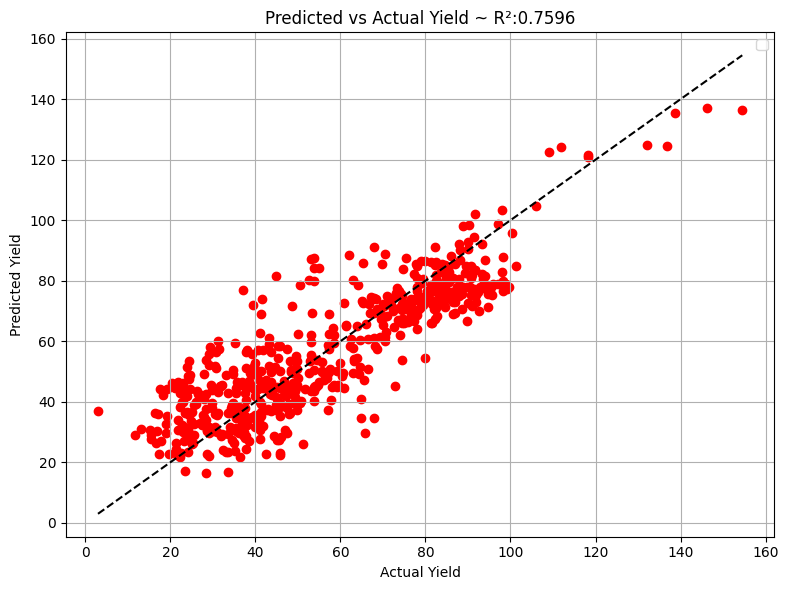

In [139]:

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(results_df['actual'], results_df['predicted'],color='red')

# Add y = x line
min_val = min(results_df['actual'].min(), results_df['predicted'].min())
max_val = max(results_df['actual'].max(), results_df['predicted'].max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black')

# Labels and title
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title(f'Predicted vs Actual Yield ~ R²:{np.round(r2,4)}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [140]:
results_df[results_df['fips']=='26063']

,fips,predicted,actual
590,26063,104.821042,105.9
591,26063,103.449125,97.9
592,26063,102.077208,91.7


## Wheat (EMA)

### Clean Data

In [198]:
wheat_natl=pl.read_csv(r'C:\Users\Porter\Desktop\Huron\Research\county_yields\winter_wheat_natl.csv')



wheat_natl=wheat_natl.filter(pl.col('Program')=='SURVEY')
wheat_natl=wheat_natl.select(['Year','County','State ANSI','County ANSI','Value'])


wheat_natl=wheat_natl.with_columns(
   (( pl.col('State ANSI').cast(pl.Utf8).str.zfill(2)) +
   (pl.col('County ANSI').cast(pl.Utf8).str.zfill(3)))
   .alias('fips')
)
wheat_natl=wheat_natl.rename({'Value':'yield'})

#get rid of duplicates
wheat_natl = (
    wheat_natl
    .group_by(['fips', 'Year'])
    .agg([
        pl.col('yield').mean().alias('yield')
    ])
)


fips_count=((wheat_natl.group_by(pl.col('fips')).agg(pl.col('Year').count())))
fips_count=fips_count.rename({'Year':'fips_count'})


In [199]:
wheat_natl=wheat_natl.join(fips_count,on='fips')
wheat_natl=wheat_natl.sort(['Year','fips'],descending=True)

In [200]:
wheat_natl=wheat_natl.filter(pl.col('fips_count')>21)
wheat_natl['fips'].n_unique()

1036

### EMA

In [201]:
preds = []
truth = []
fips_list = []

alpha = .7  # EMA smoothing factor

for county in wheat_natl['fips'].unique():
    sub = (
        wheat_natl.filter(pl.col('fips') == county)
        .sort('Year', descending=False)  # ascending year order
        .to_pandas()
    )

    if len(sub) < 2:
        continue  # not enough data to train and test

    # Use all but last year as training
    train = sub[:-1]
    test = sub.iloc[-1]  # last year only

    # Compute EMA on training set
    ema_series = train['yield'].ewm(alpha=alpha, adjust=False).mean()
    last_ema = ema_series.iloc[-1]

    preds.append(last_ema)
    truth.append(test['yield'])
    fips_list.append(county)


In [202]:
results_df = pd.DataFrame({
    'fips': fips_list,
    'predicted': preds,
    'actual': truth
})

results_df

,fips,predicted,actual
0,48145,39.290390,46.8
1,20157,52.201044,55.9
2,37187,65.690424,50.1
3,26087,76.673210,79.7
4,26075,73.827295,62.5
...,...,...,...
1031,18065,79.757674,111.3
1032,05107,54.189725,63.2
1033,48117,28.161592,37.6
1034,20177,47.967923,59.0


In [203]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Assuming you already have a DataFrame called `results_df`
y_true = results_df['actual']
y_pred = results_df['predicted']

# R² Score
r2 = r2_score(y_true, y_pred)

# RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# MAE
mae = mean_absolute_error(y_true, y_pred)

# MAPE (in percent)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Print the results
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")


R²: 0.7063
RMSE: 12.9437
MAE: 10.1848
MAPE: 20.01%


C:\Users\Porter\AppData\Local\Temp\ipykernel_22376\4124835449.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


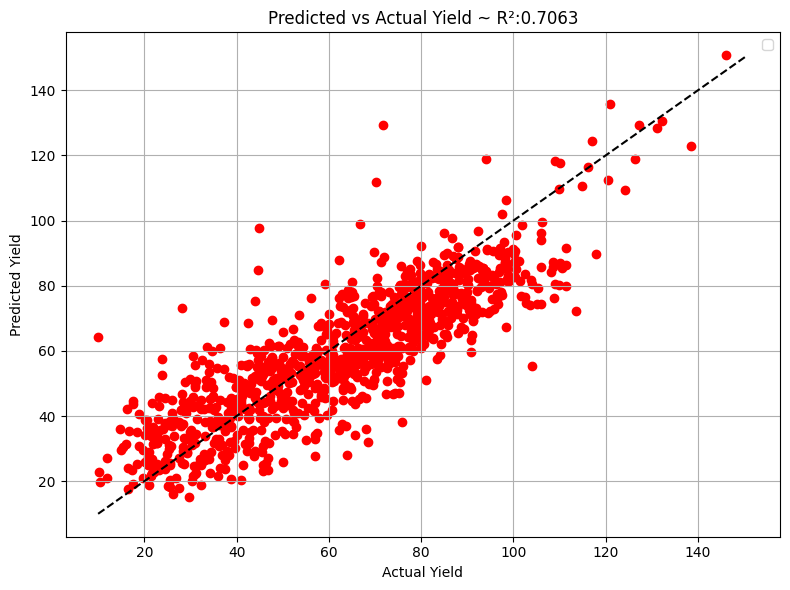

In [204]:

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(results_df['actual'], results_df['predicted'],color='red')

# Add y = x line
min_val = min(results_df['actual'].min(), results_df['predicted'].min())
max_val = max(results_df['actual'].max(), results_df['predicted'].max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black')

# Labels and title
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title(f'Predicted vs Actual Yield ~ R²:{np.round(r2,4)}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [205]:
results_df[results_df['fips']=='26063']

,fips,predicted,actual
905,26063,96.152345,105.9


## Wheat (with 200 from Geojson) [OLS trained on most recent]

### Clean Data

In [184]:
wheat_natl=pl.read_csv(r'C:\Users\Porter\Desktop\Huron\Research\county_yields\winter_wheat_natl.csv')



wheat_natl=wheat_natl.filter(pl.col('Program')=='SURVEY')
wheat_natl=wheat_natl.select(['Year','County','State ANSI','County ANSI','Value'])


wheat_natl=wheat_natl.with_columns(
   (( pl.col('State ANSI').cast(pl.Utf8).str.zfill(2)) +
   (pl.col('County ANSI').cast(pl.Utf8).str.zfill(3)))
   .alias('fips')
)
wheat_natl=wheat_natl.rename({'Value':'yield'})

#get rid of duplicates
wheat_natl = (
    wheat_natl
    .group_by(['fips', 'Year'])
    .agg([
        pl.col('yield').mean().alias('yield')
    ])
)


fips_count=((wheat_natl.group_by(pl.col('fips')).agg(pl.col('Year').count())))
fips_count=fips_count.rename({'Year':'fips_count'})


In [185]:
wheat_natl=wheat_natl.join(fips_count,on='fips')
wheat_natl=wheat_natl.sort(['Year','fips'],descending=True)

In [186]:
wheat_natl=wheat_natl.filter(pl.col('fips_count')>21)
wheat_natl['fips'].n_unique()

1036

### OLS

In [189]:
preds=[]
truth=[]
fips_list=[]


for county in wheat_natl['fips'].unique():
    sub=wheat_natl.filter(
        pl.col('fips')==county
    ).sort('Year',descending=True)


    length=int((len(sub))*(1/8))



    sub=sub.to_pandas()
    train = sub[2:12] # last 10 exlcluding last 2
    X=sm.add_constant(train['Year'])
    y=train['yield']

    model = sm.OLS(y,X)
    results = model.fit()
    
    test=sub[:2] #last 2 obs
    X_test = sm.add_constant(test['Year'])  
    predictions = results.predict(X_test)


    preds.append(predictions)
    truth.append(test['yield'])
    fips_list.extend([county] * 2)



In [190]:
import pandas as pd

all_preds = pd.concat(preds, ignore_index=True)
all_truth = pd.concat(truth, ignore_index=True)
results_df = pd.DataFrame({
    'fips': fips_list,
    'predicted': all_preds,
    'actual': all_truth
})
results_df

,fips,predicted,actual
0,55027,80.023636,94.1
1,55027,79.240000,84.9
2,51011,43.848511,63.3
3,51011,45.656196,52.7
4,20031,46.985574,50.1
...,...,...,...
2067,17135,80.890816,86.7
2068,37103,61.973626,55.4
2069,37103,60.785714,44.6
2070,20165,35.211287,39.8


filter the results to only the 200 geojson ones

In [191]:
gdf=gpd.read_file(r"C:\Users\Porter\Desktop\Huron\top_200_fixed.geojson")
good_fips=gdf['fips']
good_fips=pd.DataFrame(good_fips)
good_fips

,fips
0,40093
1,30051
2,17189
3,48139
4,21213
...,...
195,40129
196,16069
197,26063
198,20021


In [192]:
merged=good_fips.merge(results_df,on=['fips'],how='inner')

In [193]:
merged

,fips,predicted,actual
0,40093,50.579545,22.7
1,40093,48.732386,26.0
2,30051,37.775758,37.4
3,30051,37.913333,21.1
4,17189,79.561818,97.0
...,...,...,...
395,26063,93.240000,97.9
396,20021,55.194858,79.9
397,20021,54.729385,63.3
398,26037,78.038182,75.4


In [194]:
results_df=merged

In [195]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Assuming you already have a DataFrame called `results_df`
y_true = results_df['actual']
y_pred = results_df['predicted']

# R² Score
r2 = r2_score(y_true, y_pred)

# RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# MAE
mae = mean_absolute_error(y_true, y_pred)

# MAPE (in percent)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Print the results
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")


R²: 0.7310
RMSE: 13.5458
MAE: 10.7065
MAPE: 28.89%


C:\Users\Porter\AppData\Local\Temp\ipykernel_22376\4124835449.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


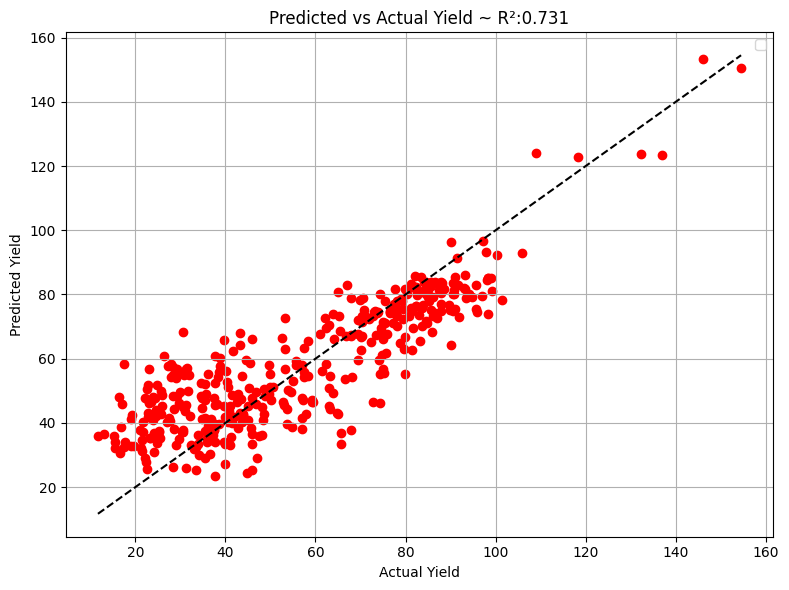

In [196]:

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(results_df['actual'], results_df['predicted'],color='red')

# Add y = x line
min_val = min(results_df['actual'].min(), results_df['predicted'].min())
max_val = max(results_df['actual'].max(), results_df['predicted'].max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black')

# Labels and title
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title(f'Predicted vs Actual Yield ~ R²:{np.round(r2,4)}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [197]:
results_df[results_df['fips']=='26063']

,fips,predicted,actual
394,26063,93.038182,105.9
395,26063,93.240000,97.9


## Soy (EMA)

### Clean Data

In [3]:
wheat_natl=pl.read_csv(r'C:\Users\Porter\Desktop\Huron\Research\county_yields\soy_county_yield.csv')



wheat_natl=wheat_natl.filter(pl.col('Program')=='SURVEY')
wheat_natl=wheat_natl.select(['Year','County','State ANSI','County ANSI','Value'])


wheat_natl=wheat_natl.with_columns(
   (( pl.col('State ANSI').cast(pl.Utf8).str.zfill(2)) +
   (pl.col('County ANSI').cast(pl.Utf8).str.zfill(3)))
   .alias('fips')
)
wheat_natl=wheat_natl.rename({'Value':'yield'})

#get rid of duplicates
wheat_natl = (
    wheat_natl
    .group_by(['fips', 'Year'])
    .agg([
        pl.col('yield').mean().alias('yield')
    ])
)


fips_count=((wheat_natl.group_by(pl.col('fips')).agg(pl.col('Year').count())))
fips_count=fips_count.rename({'Year':'fips_count'})


In [4]:
wheat_natl=wheat_natl.join(fips_count,on='fips')
wheat_natl=wheat_natl.sort(['Year','fips'],descending=True)

In [5]:
wheat_natl=wheat_natl.filter(pl.col('fips_count')>21)
wheat_natl['fips'].n_unique()

1066

### EMA

In [6]:
preds = []
truth = []
fips_list = []

alpha = .7  # EMA smoothing factor

for county in wheat_natl['fips'].unique():
    sub = (
        wheat_natl.filter(pl.col('fips') == county)
        .sort('Year', descending=False)  # ascending year order
        .to_pandas()
    )

    if len(sub) < 2:
        continue  # not enough data to train and test

    # Use all but last year as training
    train = sub[:-1]
    test = sub.iloc[-1]  # last year only

    # Compute EMA on training set
    ema_series = train['yield'].ewm(alpha=alpha, adjust=False).mean()
    last_ema = ema_series.iloc[-1]

    preds.append(last_ema)
    truth.append(test['yield'])
    fips_list.append(county)


In [7]:
results_df = pd.DataFrame({
    'fips': fips_list,
    'predicted': preds,
    'actual': truth
})

results_df

,fips,predicted,actual
0,40103,14.243929,9.0
1,51047,41.229015,51.8
2,19179,54.762961,61.7
3,47071,40.023168,48.8
4,18023,65.722406,64.6
...,...,...,...
1061,26147,39.183717,44.0
1062,29109,39.131525,33.6
1063,39151,54.666968,50.2
1064,17007,60.566857,62.9


In [8]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Assuming you already have a DataFrame called `results_df`
y_true = results_df['actual']
y_pred = results_df['predicted']

# R² Score
r2 = r2_score(y_true, y_pred)

# RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# MAE
mae = mean_absolute_error(y_true, y_pred)

# MAPE (in percent)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Print the results
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")


R²: 0.6379
RMSE: 6.9159
MAE: 5.3500
MAPE: 12.71%


C:\Users\Porter\AppData\Local\Temp\ipykernel_15160\4124835449.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


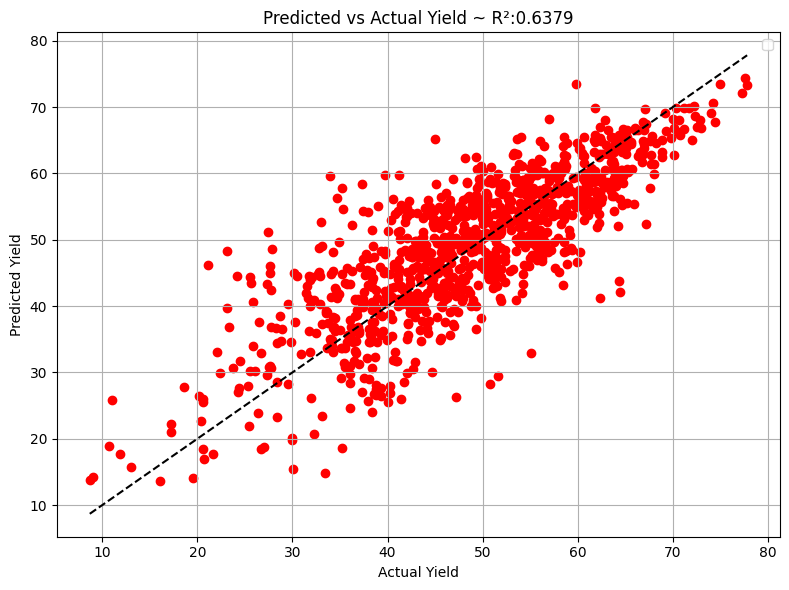

In [9]:

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(results_df['actual'], results_df['predicted'],color='red')

# Add y = x line
min_val = min(results_df['actual'].min(), results_df['predicted'].min())
max_val = max(results_df['actual'].max(), results_df['predicted'].max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black')

# Labels and title
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title(f'Predicted vs Actual Yield ~ R²:{np.round(r2,4)}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
results_df[results_df['fips']=='26063']

,fips,predicted,actual
697,26063,48.413596,57.2


## Wheat (with 200 from Geojson EMA)

### Clean Data

In [16]:
wheat_natl=pl.read_csv(r'C:\Users\Porter\Desktop\Huron\Research\county_yields\winter_wheat_natl.csv')



wheat_natl=wheat_natl.filter(pl.col('Program')=='SURVEY')
wheat_natl=wheat_natl.select(['Year','County','State ANSI','County ANSI','Value'])


wheat_natl=wheat_natl.with_columns(
   (( pl.col('State ANSI').cast(pl.Utf8).str.zfill(2)) +
   (pl.col('County ANSI').cast(pl.Utf8).str.zfill(3)))
   .alias('fips')
)
wheat_natl=wheat_natl.rename({'Value':'yield'})

#get rid of duplicates
wheat_natl = (
    wheat_natl
    .group_by(['fips', 'Year'])
    .agg([
        pl.col('yield').mean().alias('yield')
    ])
)


fips_count=((wheat_natl.group_by(pl.col('fips')).agg(pl.col('Year').count())))
fips_count=fips_count.rename({'Year':'fips_count'})


In [17]:
wheat_natl=wheat_natl.join(fips_count,on='fips')
wheat_natl=wheat_natl.sort(['Year','fips'],descending=True)

In [18]:
wheat_natl=wheat_natl.filter(pl.col('fips_count')>21)
wheat_natl['fips'].n_unique()

1036

### EMA

In [19]:
preds = []
truth = []
fips_list = []

alpha = .7  # EMA smoothing factor

for county in wheat_natl['fips'].unique():
    sub = (
        wheat_natl.filter(pl.col('fips') == county)
        .sort('Year', descending=False)  # ascending year order
        .to_pandas()
    )

    if len(sub) < 2:
        continue  # not enough data to train and test

    # Use all but last year as training
    train = sub[:-1]
    test = sub.iloc[-1]  # last year only

    # Compute EMA on training set
    ema_series = train['yield'].ewm(alpha=alpha, adjust=False).mean()
    last_ema = ema_series.iloc[-1]

    preds.append(last_ema)
    truth.append(test['yield'])
    fips_list.append(county)


In [20]:
results_df = pd.DataFrame({
    'fips': fips_list,
    'predicted': preds,
    'actual': truth
})

results_df

,fips,predicted,actual
0,41021,42.556202,34.0
1,48085,56.420127,52.5
2,53043,55.372982,53.3
3,39039,76.854806,69.5
4,18005,88.163511,98.2
...,...,...,...
1031,36011,61.425541,79.9
1032,17059,95.579399,100.5
1033,20131,60.242894,65.2
1034,55115,70.843923,65.2


filter the results to only the 200 geojson ones

In [21]:
gdf=gpd.read_file(r"C:\Users\Porter\Desktop\Huron\top_200_fixed.geojson")
good_fips=gdf['fips']
good_fips=pd.DataFrame(good_fips)
good_fips

,fips
0,40093
1,30051
2,17189
3,48139
4,21213
...,...
195,40129
196,16069
197,26063
198,20021


In [22]:
merged=good_fips.merge(results_df,on=['fips'],how='inner')

In [23]:
merged

,fips,predicted,actual
0,40093,31.584894,22.7
1,30051,23.649708,37.4
2,17189,90.313656,97.0
3,48139,44.682200,49.7
4,21213,85.644109,88.1
...,...,...,...
195,40129,19.943997,30.3
196,16069,74.993646,78.0
197,26063,96.152345,105.9
198,20021,60.914287,79.9


In [24]:
results_df=merged

In [25]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Assuming you already have a DataFrame called `results_df`
y_true = results_df['actual']
y_pred = results_df['predicted']

# R² Score
r2 = r2_score(y_true, y_pred)

# RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# MAE
mae = mean_absolute_error(y_true, y_pred)

# MAPE (in percent)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Print the results
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")


R²: 0.7993
RMSE: 11.5476
MAE: 9.2777
MAPE: 19.73%


C:\Users\Porter\AppData\Local\Temp\ipykernel_15160\4124835449.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


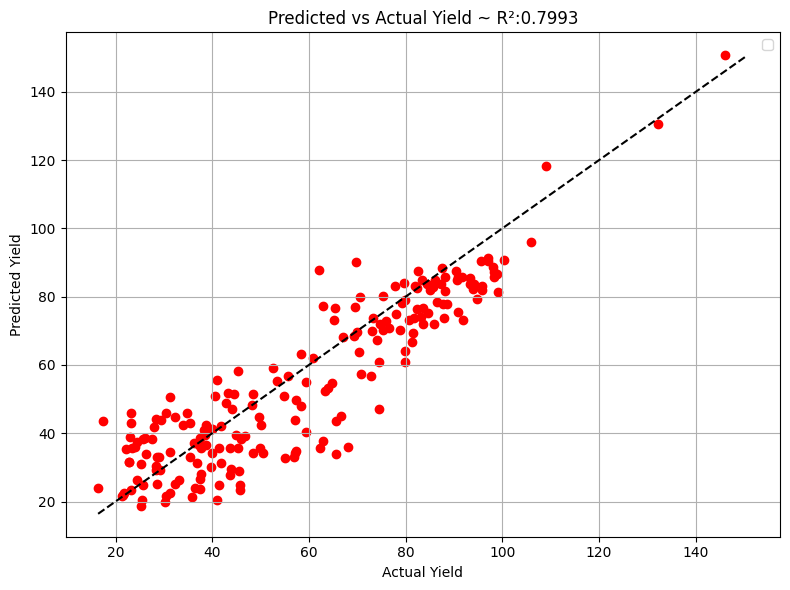

In [26]:

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(results_df['actual'], results_df['predicted'],color='red')

# Add y = x line
min_val = min(results_df['actual'].min(), results_df['predicted'].min())
max_val = max(results_df['actual'].max(), results_df['predicted'].max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black')

# Labels and title
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title(f'Predicted vs Actual Yield ~ R²:{np.round(r2,4)}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
results_df[results_df['fips']=='26063']

,fips,predicted,actual
197,26063,96.152345,105.9


## Wheat (with 200 from Geojson EMA extrapolate)

### Clean Data

In [2]:
wheat_natl=pl.read_csv(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\winter_wheat_natl.csv')



wheat_natl=wheat_natl.filter(pl.col('Program')=='SURVEY')
wheat_natl=wheat_natl.select(['Year','County','State ANSI','County ANSI','Value'])


wheat_natl=wheat_natl.with_columns(
   (( pl.col('State ANSI').cast(pl.Utf8).str.zfill(2)) +
   (pl.col('County ANSI').cast(pl.Utf8).str.zfill(3)))
   .alias('fips')
)
wheat_natl=wheat_natl.rename({'Value':'yield'})

#get rid of duplicates
wheat_natl = (
    wheat_natl
    .group_by(['fips', 'Year'])
    .agg([
        pl.col('yield').mean().alias('yield')
    ])
)


fips_count=((wheat_natl.group_by(pl.col('fips')).agg(pl.col('Year').count())))
fips_count=fips_count.rename({'Year':'fips_count'})


In [3]:
wheat_natl=wheat_natl.join(fips_count,on='fips')
wheat_natl=wheat_natl.sort(['Year','fips'],descending=True)

In [4]:
wheat_natl=wheat_natl.filter(pl.col('fips_count')>21)
wheat_natl['fips'].n_unique()

1036

### EMA

In [5]:
preds = []
truth = []
fips_list = []

alpha = 0.7  # EMA smoothing factor

for county in wheat_natl['fips'].unique():
    sub = (
        wheat_natl.filter(pl.col('fips') == county)
        .sort('Year')  # ascending year order
        .to_pandas()
    )

    if len(sub) < 2:
        continue  # not enough data to train and test

    # Use all but last year as training
    train = sub[:-1]
    test = sub.iloc[-1]  # actual yield for next year

    # Compute EMA on training set
    ema_series = train['yield'].ewm(alpha=alpha, adjust=False).mean()
    last_ema = ema_series.iloc[-1]
    last_actual = train['yield'].iloc[-1]

    # Predict the next year's yield using EMA update rule
    predicted_next = alpha * last_actual + (1 - alpha) * last_ema

    preds.append(predicted_next)
    truth.append(test['yield'])
    fips_list.append(county)


In [6]:
results_df = pd.DataFrame({
    'fips': fips_list,
    'predicted': preds,
    'actual': truth
})

results_df

,fips,predicted,actual
0,47103,74.300941,82.6
1,39133,76.331613,79.8
2,55075,63.126345,59.3
3,20129,25.541280,42.2
4,39097,77.890304,86.8
...,...,...,...
1031,18081,82.144691,105.3
1032,05069,54.684995,49.9
1033,31029,44.654084,63.0
1034,24015,89.981720,98.1


filter the results to only the 200 geojson ones

In [7]:
gdf=gpd.read_file(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\top_200_fixed.geojson')
good_fips=gdf['fips']
good_fips=pd.DataFrame(good_fips)
good_fips

,fips
0,40093
1,30051
2,17189
3,48139
4,21213
...,...
195,40129
196,16069
197,26063
198,20021


In [8]:
merged=good_fips.merge(results_df,on=['fips'],how='inner')

In [9]:
merged

,fips,predicted,actual
0,40093,27.675468,22.7
1,30051,21.864912,37.4
2,17189,92.544097,97.0
3,48139,42.384660,49.7
4,21213,87.153233,88.1
...,...,...,...
195,40129,16.623199,30.3
196,16069,78.148094,78.0
197,26063,97.375704,105.9
198,20021,62.584286,79.9


In [10]:
results_df=merged

In [11]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Assuming you already have a DataFrame called `results_df`
y_true = results_df['actual']
y_pred = results_df['predicted']

# R² Score
r2 = r2_score(y_true, y_pred)

# RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# MAE
mae = mean_absolute_error(y_true, y_pred)

# MAPE (in percent)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Print the results
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")


R²: 0.7699
RMSE: 12.3658
MAE: 9.9053
MAPE: 20.82%


C:\Users\porter77.BYU\AppData\Local\Temp\ipykernel_35480\4124835449.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


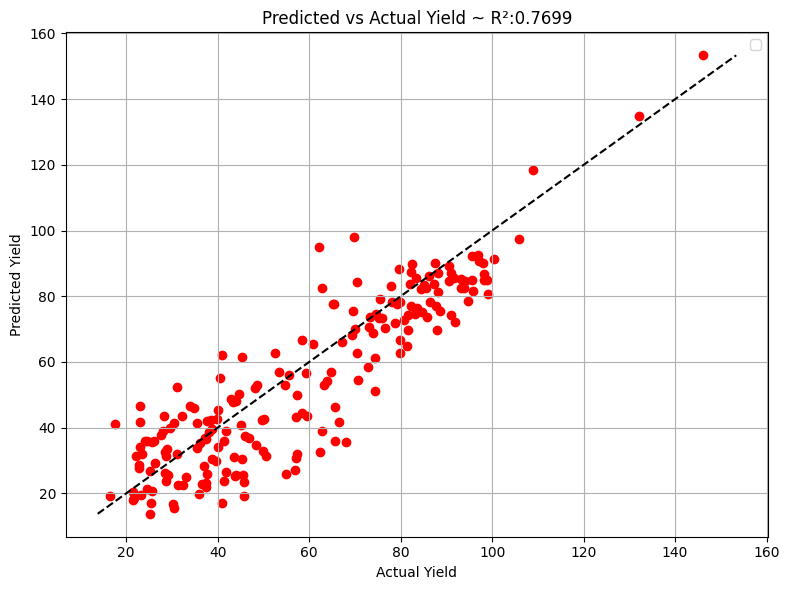

In [12]:

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(results_df['actual'], results_df['predicted'],color='red')

# Add y = x line
min_val = min(results_df['actual'].min(), results_df['predicted'].min())
max_val = max(results_df['actual'].max(), results_df['predicted'].max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black')

# Labels and title
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title(f'Predicted vs Actual Yield ~ R²:{np.round(r2,4)}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
results_df[results_df['fips']=='26063']

,fips,predicted,actual
197,26063,97.375704,105.9


: 